In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    
    def policy_fn(observation):
        return A
    
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        probs = np.zeros(len(Q[observation]), dtype=float)
        probs[np.argmax(Q[observation])] = 1.0
        
        return probs
        
    return policy_fn

In [8]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Maintain for each state,action the cumulative sum of
    # weights given for the first n returns
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    def generate_episode(policy):
        episode = []
        current_state = env.reset()
        
        while True:
            action = np.random.choice(env.action_space.n, p=policy(current_state))
            next_state, reward, done, _ = env.step(action)
            episode.append((current_state, action, reward))
            
            if done:
                break

            current_state = next_state
        
        return episode

    for e in range(1, num_episodes+1):
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        
        episode = generate_episode(behavior_policy)
        
        G, W = .0, 1.0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = reward + discount_factor * G
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            
            greedy_action = np.argmax(target_policy(state))
            if greedy_action != action:
                break
            
            W /= behavior_policy(state)[action]
    
    return Q, target_policy

In [9]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

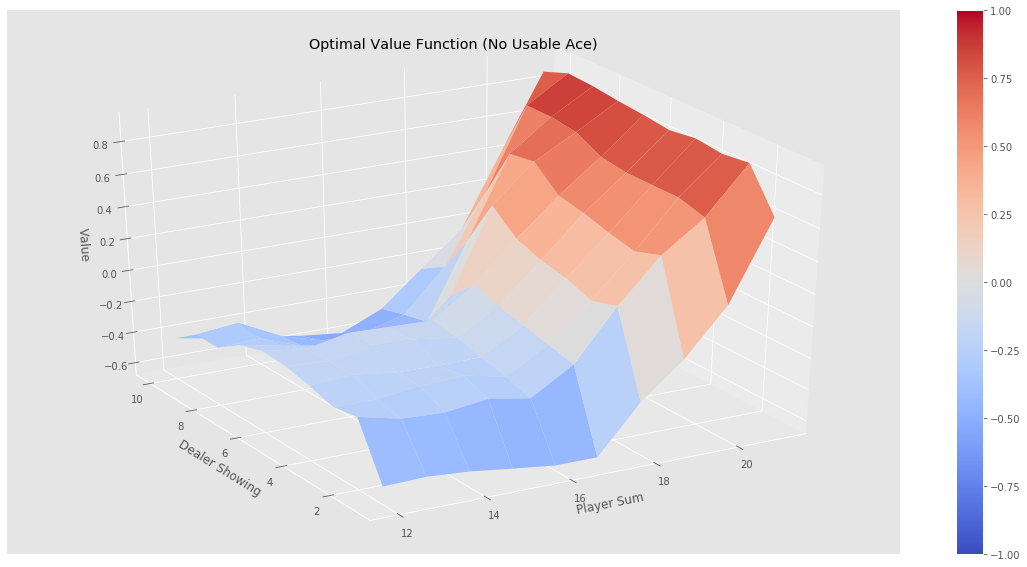

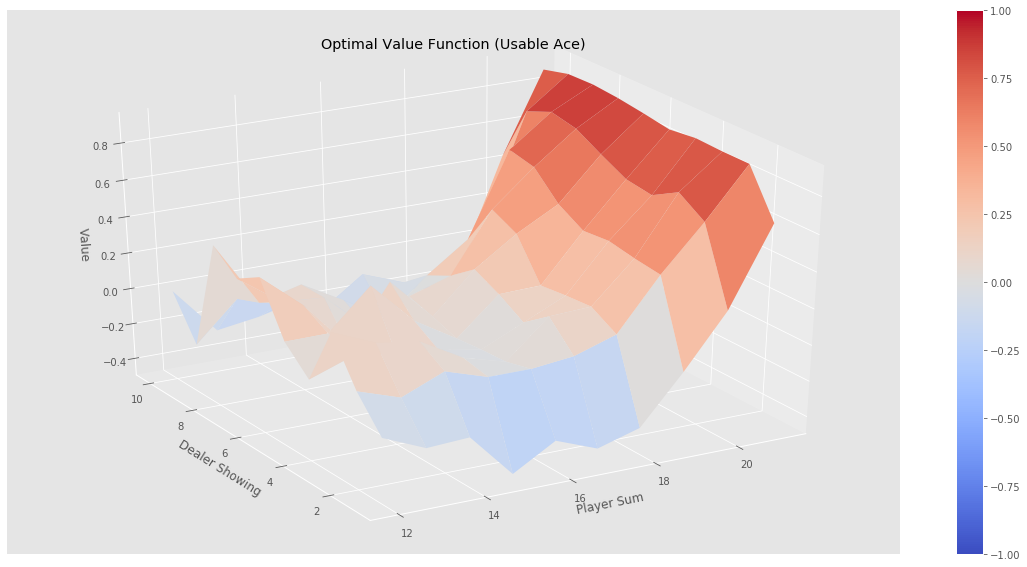

In [10]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")